Loading shapefile from: BR_Pais_2024/BR_Pais_2024.shp
Shapefile loaded successfully.

Using hard-coded income share data as requested.

Calculated Income Shares:
Bottom 50% (p0p50): 0.0912
Middle 40% (p50p90): 0.3167 (Calculated as remainder)
Next 9% (p90p99): 0.3808 (Calculated as p90p100 - p99p100)
Top 1% (p99p100): 0.2113

Manually dividing polygon based on percentages...


C:\Users\daves\AppData\Local\Temp\ipykernel_11956\137116850.py:44: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  brazil_geom = brazil_map.geometry.unary_union


Creating final plot...

Successfully saved combined plot to brazil_map_divided.jpg at 1200 DPI


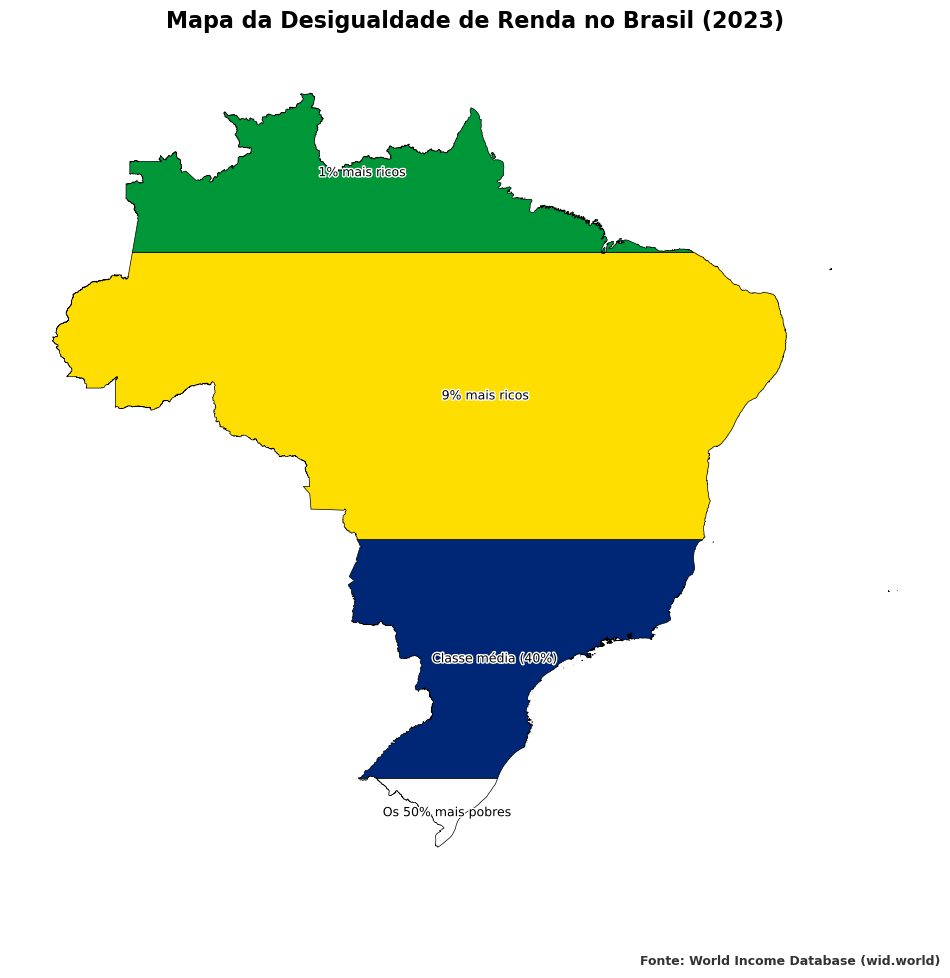

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from shapely.geometry import box
import matplotlib.patheffects as patheffects
from matplotlib.colors import ListedColormap 

# --- 1. Define File Paths ---
shp_path = r"BR_Pais_2024/BR_Pais_2024.shp"

# --- 2. Load the Geospatial Data ---
print(f"Loading shapefile from: {shp_path}")
if not os.path.exists(shp_path):
    print(f"Error: Shapefile not found at {shp_path}")
    print("Please check the 'shp_path' variable in the script.")
    brazil_map = None
else:
    brazil_map = gpd.read_file(shp_path)
    print("Shapefile loaded successfully.")

# --- 3. Income data (from wid.world and in 2013 values) ---
print("\nUsing hard-coded income share data as requested.")
val_p0p50 = 0.0912
val_p99p100 = 0.2113
val_p90p100 = 0.5921000000000001

# --- 4. Calculate Shares (Proceed only if map loaded) ---
if brazil_map is not None:
    
    val_p90p99 = val_p90p100 - val_p99p100
    val_p50p90 = 1.0 - val_p0p50 - val_p90p99 - val_p99p100

    print("\nCalculated Income Shares:")
    print(f"Bottom 50% (p0p50): {val_p0p50:.4f}")
    print(f"Middle 40% (p50p90): {val_p50p90:.4f} (Calculated as remainder)")
    print(f"Next 9% (p90p99): {val_p90p99:.4f} (Calculated as p90p100 - p99p100)")
    print(f"Top 1% (p99p100): {val_p99p100:.4f}")

    # --- 5. Manually Divide the Polygon ---

    print("\nManually dividing polygon based on percentages...")

    brazil_geom = brazil_map.geometry.unary_union
    minx, miny, maxx, maxy = brazil_geom.bounds
    total_height = maxy - miny

    y_split1 = miny + total_height * val_p0p50
    clipper1 = box(minx, miny, maxx, y_split1)
    poly1 = brazil_geom.intersection(clipper1)
    
    y_split2 = y_split1 + total_height * val_p50p90
    clipper2 = box(minx, y_split1, maxx, y_split2)
    poly2 = brazil_geom.intersection(clipper2)

    y_split3 = y_split2 + total_height * val_p90p99
    clipper3 = box(minx, y_split2, maxx, y_split3)
    poly3 = brazil_geom.intersection(clipper3)
    
    clipper4 = box(minx, y_split3, maxx, maxy)
    poly4 = brazil_geom.intersection(clipper4)

    label_p0p50 = 'Os 50% mais pobres'
    label_p50p90 = 'Classe média (40%)'
    label_p90p99 = '9% mais ricos'
    label_p99p100 = '1% mais ricos'
    
    data = [
        {'group': label_p0p50, 'geometry': poly1},
        {'group': label_p50p90, 'geometry': poly2},
        {'group': label_p90p99, 'geometry': poly3},
        {'group': label_p99p100, 'geometry': poly4},
    ]

    gdf_divided = gpd.GeoDataFrame(data, crs=brazil_map.crs)

    # --- 6. Create the Visualization ---

    print("Creating final plot...")

    brazil_colors = ['#009739', '#FEDD00', '#002776', '#FFFFFF'] # Verde, Amarelo, Azul, Branco

    cmap_brazil = ListedColormap(brazil_colors)

    fig, ax_map = plt.subplots(figsize=(12, 12))

    gdf_divided.plot(
        ax=ax_map,
        column='group',
        categorical=True,
        edgecolor='black',
        linewidth=0.5,
        cmap=cmap_brazil 
    )
    
    for idx, row in gdf_divided.iterrows():
        if not row.geometry.is_empty:
            point = row.geometry.representative_point()

            

            text_color = 'black'
            
            ax_map.annotate(
                text=row['group'],
                xy=(point.x, point.y),
                ha='center',
                va='center',
                fontsize=9,
                color=text_color, 
                path_effects=[patheffects.withStroke(linewidth=2, foreground='white')]
            )
    
    ax_map.set_title(
        'Mapa da Desigualdade de Renda no Brasil (2023)', 
        fontsize=16, 
        pad=20, 
        fontweight='bold'
    )
    ax_map.axis('off')

    fig.text(0.90, 0.08, 'Fonte: World Income Database (wid.world)', 
             ha='right', 
             va='bottom', 
             fontsize=9, 
             color='#333333',
             fontweight='bold'
    )

    output_filename = 'brazil_map_divided.jpg'
    try:
        plt.savefig(
            output_filename, 
            bbox_inches='tight',
            dpi=1200
        )
        print(f"\nSuccessfully saved combined plot to {output_filename} at 1200 DPI")
        # plt.show()
    except Exception as e:
        print(f"\nError saving plot: {e}")

else:
    print("\nSkipping visualization because the shapefile could not be loaded.")